+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

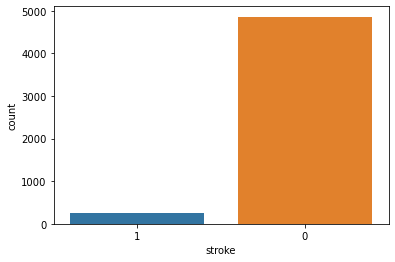

4084


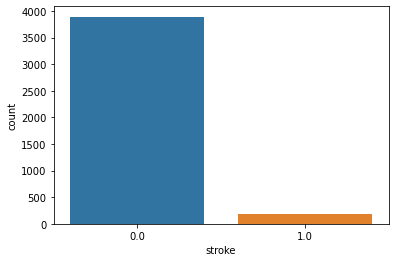

1026


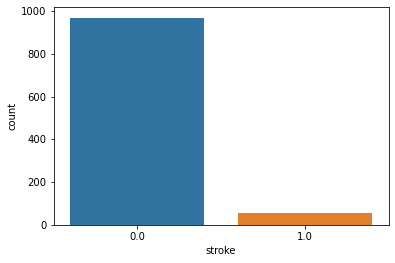

+---+------------+-----------------+--------------+-------------------+-------------------+----+------------+-------------+-----------------+-----+------+
| x0|genderEncode|EverMarriedEncode|WorkTypeEncode|ResidenceTypeEncode|SmokingStatusEncode| age|hypertension|heart_disease|avg_glucose_level|  bmi|stroke|
+---+------------+-----------------+--------------+-------------------+-------------------+----+------------+-------------+-----------------+-----+------+
|1.0|         0.0|              0.0|           0.0|                0.0|                0.0|27.0|         0.0|          0.0|            65.43| 27.2|   0.0|
|1.0|         0.0|              0.0|           0.0|                0.0|                0.0|37.0|         0.0|          0.0|            76.21| 20.4|   0.0|
|1.0|         0.0|              0.0|           0.0|                0.0|                0.0|46.0|         0.0|          0.0|           112.29| 23.5|   0.0|
|1.0|         0.0|              0.0|           0.0|                0.0

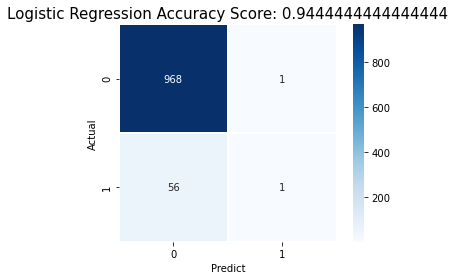

In [1]:
df = spark.read.format("csv").option("header", "true").load("healthcare-dataset-stroke-data.csv")

df.show()

df.printSchema()

# Delete id column
df = df.drop('id')

from pyspark.ml.feature import StringIndexer

#Encode categories attributes
inputs = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
outputs = ["genderEncode", "EverMarriedEncode", "WorkTypeEncode", "ResidenceTypeEncode", "SmokingStatusEncode"]
indexer = StringIndexer(inputCols=inputs, outputCols=outputs, stringOrderType='alphabetAsc')
indexed = indexer.fit(df).transform(df)

indexed = indexed.drop('gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status')

indexed.printSchema()

#Calculate mean of bmi column
indexedTypedf = indexed.withColumn("bmiDouble", indexed["bmi"].cast("double"))
indexedTypedf.groupBy().mean('bmiDouble').show()

#Replace "N/A" value with 28.89
from pyspark.sql.functions import regexp_replace
indexed = indexed.withColumn('bmi', regexp_replace('bmi', 'N/A', '28.89'))

from pyspark.sql.types import DoubleType
indexed = indexed.withColumn("age",indexed.age.cast(DoubleType()))
indexed = indexed.withColumn("hypertension",indexed.hypertension.cast(DoubleType()))
indexed = indexed.withColumn("heart_disease",indexed.heart_disease.cast(DoubleType()))
indexed = indexed.withColumn("avg_glucose_level",indexed.avg_glucose_level.cast(DoubleType()))
indexed = indexed.withColumn("bmi",indexed.bmi.cast(DoubleType()))


indexed.createOrReplaceTempView("patient")
#Print the tables in catalog
print(spark.catalog.listTables())
indexed.show()

#indexed.write.csv('dataset.csv',header = 'true')

#Kiem tra phan phoi cua bien phan lop
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='stroke', data = indexed.toPandas())
plt.show()

#mean, count, min, max, ...
indexed.select("age","hypertension","heart_disease","avg_glucose_level","bmi").describe().toPandas().transpose()

from pyspark.sql.functions import lit
indexed = indexed.withColumn("x0", lit(1))
indexed = indexed.withColumn("stroke", indexed.stroke.cast(DoubleType()))
indexed = indexed.withColumn("x0", indexed.x0.cast(DoubleType()))
indexed = indexed.select("x0","genderEncode", "EverMarriedEncode", "WorkTypeEncode", "ResidenceTypeEncode","SmokingStatusEncode","age","hypertension","heart_disease","avg_glucose_level","bmi","stroke")

df_train, df_test = indexed.randomSplit([0.8, 0.2], seed = 17)
print(df_train.count())
sns.countplot(x='stroke', data = df_train.toPandas())
plt.show()
print(df_test.count())
sns.countplot(x='stroke', data = df_test.toPandas())
plt.show()

df_train.show()

import numpy as geek
from random import random
def sigmoid(z):
      return 1.0/(1.0 + geek.exp(-z))

def gradient_descent(data, theta, step, iter_max):
      m = data.count()
      for i in range(iter_max):
            grad = []
            for j in range(len(theta)):
               temp = data.map(lambda p: (sigmoid(geek.dot(p[:len(theta)], theta))-p[-1])*p[j]).reduce(lambda a,b: a+b)
               grad.append(temp)
            grad = geek.array(grad)
            grad = grad/m
            if((abs(grad) < 0.05).all()==True):
               print("----STOP----")
               break
            print(grad)
            print(theta)
            theta = theta - step*grad
      return theta

def classification(l):
      if l >= 0.5:
         return 1
      return 0

def cal_confusion_matrix(label, p):
      if label == p:
          if label == 1:
             return ('TP', 1)
          elif label == 0:
             return ('TN', 1)
      elif label != p:
          if label == 1:
             return ('FN', 1)
          elif label == 0:
             return ('FP', 1)

def getValueByKey(array, key):
      value = 0
      for i in array:
           if i[0] == key:
              value = i[1]
              break
      return value

def score(test,theta):
      confusion_matrix = test.map(lambda line:[line[-1],classification(sigmoid(geek.dot(line[:len(theta)],theta)))])
      confusion_matrix = confusion_matrix.map(lambda m:cal_confusion_matrix(m[0],m[1]))
      confusion_matrix = confusion_matrix.reduceByKey(lambda a,b: a+b)
      TP = getValueByKey(confusion_matrix.collect(),'TP')
      TN = getValueByKey(confusion_matrix.collect(),'TN')
      FP = getValueByKey(confusion_matrix.collect(),'FP')
      FN = getValueByKey(confusion_matrix.collect(),'FN')
      print(TP,TN,FP,FN)
      accuracy = (TP+TN)/test.count()
      lo_cm = geek.array([[TN,FP],[FN,TP]])
      precision = TP/(TP+FP)
      recall = TP/(TP+FN)
      f1_score = 2*precision*recall/(precision+recall)
      return accuracy, lo_cm, precision, recall, f1_score

import time
start_time = time.time()
theta = geek.ones(len(df_train.columns)-1)*-0.01*random()
theta = geek.array([-0.76563256,-0.13838825,-0.30681137,-0.36198578,-0.14565908,-0.13733445,0.04132808,0.45234032,0.35782729,  0.00320207,-0.12311996])
data = df_train.rdd.map(list)
step = 0.1
max_iter = 1000
theta = gradient_descent(data, theta, step, max_iter)
end_time = time.time()
print(theta)
print((end_time-start_time)/60, "minutes")

acc, lo_cm, precision, recall, f1_score = score(df_test.rdd, theta)
print('Precision: {0}'.format(precision))
print('Recall: {0}'.format(recall))
print('F1-score: {0}'.format(f1_score))
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(lo_cm,annot=True, fmt=".0f", linewidths = .5, square=True, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predict')
title = 'Logistic Regression Accuracy Score: {0}'.format(acc)
plt.title(title,size=15)
plt.show()